### 【問題1】中心点の初期値を決める
入力されたデータから $K$ 個の中心点 $\mu_1$ から $\mu_K$ の初期値を決めるコードを作成してください。$K$ は指定したクラスタ数です。<br>
最もシンプルな初期値の決定方法は、データ点 $X_n$ の中からランダムに $K$ 個選ぶことです。今回はこれを実装してください。<br>
K-meansの学習結果は中心点 $\mu$ の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。<br>


In [1]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)
print(X.shape)

(100, 2)


In [2]:
import numpy as np

# ランダム値の固定化
np.random.seed(0) 

# クラスタの数
n_clusters = 4

# １列目の値からランダムに４つの（重複しない）値を抽出
clusters = np.random.choice(X[:, 0], n_clusters)
print(clusters)
clusters_index = []
for i in clusters:
    clusters_index.append(np.where(X[:, 0] == i)[0][0])
clusters_points = X[clusters_index,:]
print(clusters_points)

[-1.87418794 -1.84482705  1.42002502 -1.32890066]
[[-1.87418794  2.84306499]
 [-1.84482705  3.25609891]
 [ 1.42002502  1.38236201]
 [-1.32890066  2.37135151]]


### 【問題2】SSEを求める関数の作成
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。<br>
K-meansはこのSSEを最小化する $r_{nk}$ と $\mu_k$ を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。<br>
<br>
　　　　$ SSE = \displaystyle\sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2 $<br>
<br>
<br>
　　　　$ n $ : データ点のインデックス<br>
　　　　$ k $ : クラスタのインデックス<br>
　　　　$ X_n $ : $ n $ 番目のデータ点<br>
　　　　$ \mu_k $ : $ k $ 番目の中心点<br>
　　　　$ r_{nk} $ :データ点 $ X_n $ がクラスタ$k$に所属していたら1、そうでなければ0<br>
<br>
<br>
### クラスタの割り当てと中心点の移動を繰り返す
K-meansの学習の基本は以下の2つのフェーズを繰り返すことです。<br>
　・中心点 $ \mu_k $ を固定した上で $ SSE $ を最小化する クラスタの割り当て $ r_{nk} $ を選ぶ。<br>
　・クラスタの割り当て $r_{nk}$ を固定した上で $SSE$ を最小化する 中心点 $\mu_k$ を選ぶ。<br>

最初の中心点 $\mu_k$ は問題1で作成した初期値です。<br>

順番に見ていきます。<br>

### 【問題3】クラスタへの割り当て
すべてのデータ点 $ X_n $ を最も近い中心点 $ \mu_k $ に割り当てるコードを作成してください。<br>
K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル $ p , q $ に対しては以下の数式で表現できます。<br>
<br>
　　　　$ \|q-p\| = \sqrt{(q-p)\cdot(q-p)} $
<br>
NumPyにはこの関数がnp.linalg.normとして用意されているため使用してください。<br>
<a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm — NumPy v1.17 Manual</a><br>
中心点 $\mu_k$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。<br>


### 【問題4】中心点の移動
中心点 $\mu_k$ を $k$ 番目のクラスタに割り当てられるすべてのデータ点 $X_n$ の平均値（重心）に移動するコードを作成してください。<br>
クラスタの割り当て $r_{nk}$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。<br>

In [3]:
def calculation_SSE(X):

    # SSEは最適なクラス数を求めるためのエルボー法に使う値。だとすると、説明おかしくね？

    # sigma_inside　列：クラスター、行：クラスターからの距離
    distance = np.zeros([X.shape[0], n_clusters])
    k = 0
    for cluster_point in clusters_points:
        distance[:,k] = np.sum(abs(X - cluster_point) ** 2, axis = 1)
        k += 1
    
    # どのクラスターまでの距離が一番近いかを判別するために、行方向(Xの要素毎)で最小値(のインデックス)をとる
    near_cluster = np.argmin(distance, axis = 1)

    # 新しい中心点を模索 & SSEを計算
    sse = 0
    new_clusters_points = np.zeros([n_clusters, X.shape[1]])
    print(distance[near_cluster==0].shape) # 4,4
    print(distance[near_cluster==1].shape) # 48,4
    print(distance[near_cluster==2].shape) # 36,4
    print(distance[near_cluster==3].shape) # 12,4
    for i in range(n_clusters):
        sse += np.sum(np.min(distance[near_cluster==i],axis = 1))
        new_clusters_points[i,:] = np.mean(X[near_cluster==i], axis = 0)

    return sse, new_clusters_points


sse, new_clusters_points = calculation_SSE(X)
print(sse)
print(new_clusters_points)


(4, 4)
(48, 4)
(36, 4)
(12, 4)
759.6165155592755
[[-1.95559936  2.74215387]
 [-0.97539979  5.94017405]
 [ 1.80098059  1.97007648]
 [-0.4949358   3.10527361]]


### 【問題5】繰り返し
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。<br>
次のどれかの条件を満たしたらこれを止めます。<br>
　・繰り返しが指定した回数に到達する。（雛形では引数max_iter）<br>
　・中心点 $\mu_k$ と重心の差の合計が指定した許容値以下になる。（雛形では引数tol）<br>


### 【問題6】異なる初期値で計算
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。<br>
複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 $\mu_k$ を保持しておきます。<br>


### 【問題7】推定
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。<br>
　・データ点 $ X_n $ と学習で決まった中心点 $ \mu_k $ に対し、 $ SSE $ を最小化する $ r_{nk} $ を選ぶ。<br>
具体的には次のことです。<br>
　・データ点 $ X_n $ を最も近い $ \mu_k $ に割り当てる。<br>


In [20]:
import numpy as np


class ScratchKMeans():
    """
    K-meansのスクラッチ実装
    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """

#         for roop_init in range(self.n_init):

        self.sse_rec = [] # SSE保存用
        first_clusters = np.random.choice(X[:, 0], n_clusters) # Xの中からランダムで最初のクラスターを抽出
        clusters_index = [] # 抽出したクラスターのindexからXを絞り込む
        # 最初のクラスター点を決める
        for i in clusters:
            clusters_index.append(np.where(X[:, 0] == i)[0][0])
        clusters_points = X[clusters_index,:]

        # 学習回数分繰り返し
        for roop_iter in range(self.max_iter):
            # クラスターの座標
            clusters_points
            # 新しい中心点、SSEを求める
            sse, near_cluster = self._calculation_SSE(X, clusters_points)
#             print("==================================================")
#             print(sse)
#             print(near_cluster)

            # 更新
            clusters_points = self.new_clusters_points

            # SSEを保存
            self.elbow_sse = sse
            self.sse_rec.append(sse)

            # パラメータ「tol」に満たなくなったら処理終了
            if np.mean(np.linalg.norm(new_clusters_points)) < self.tol:
                break

        return near_cluster


    def _calculation_SSE(self, X, clusters_points):

        # sigma_inside　列：クラスター、行：クラスターからの距離
        distance = np.zeros([X.shape[0], self.n_clusters])
        k = 0
        for cluster_point in clusters_points:
            distance[:,k] = np.sum(abs(X - cluster_point) ** 2, axis = 1)
            k += 1

        # どのクラスターまでの距離が一番近いかを判別するために、行方向(Xの要素毎)で最小値(のインデックス)をとる
        near_cluster = np.argmin(distance, axis = 1)

        # 新しい中心点を模索 & SSEを計算
        sse = 0
        self.new_clusters_points = np.zeros([n_clusters, X.shape[1]])
        for i in range(n_clusters):
            sse += np.sum(np.min(distance[near_cluster==i],axis = 1))
            self.new_clusters_points[i,:] = np.mean(X[near_cluster==i], axis = 0)

        return sse, near_cluster


    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        self.y_pred_distance = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            for j in range(X.shape[0]):
                self.y_pred_distance[j, i] = np.linalg.norm(X[j,:] - self.new_clusters_points)
        self.y_pred_near_cluster = np.argmin(self.y_pred_distance, axis = 1)

        return self.y_pred_near_cluster


skm = ScratchKMeans(n_clusters = 4, n_init=1, max_iter = 10, tol=0.05, verbose=False)
cl = skm.fit(X)

[3 1 3 3 3 3 0 1 3 1 1 1 1 1 1 2 2 0 0 2 3 1 0 2 3 0 0 3 2 2 2 1 2 2 0 3 1
 2 1 0 3 0 1 0 0 1 2 0 3 3 3 2 0 0 0 1 1 2 2 1 1 2 2 3 2 1 0 0 2 3 1 2 3 1
 3 3 0 0 2 2 2 1 0 3 2 0 2 2 3 3 3 0 3 0 0 1 1 0 1 3]


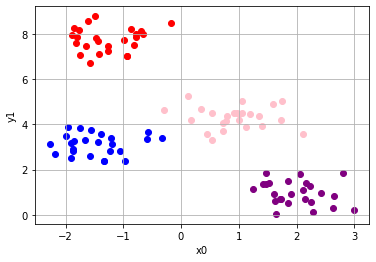

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# cl = skm.predict(X)
print(cl)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(X[:,0][cl==0], X[:,1][cl==0], c='blue')
ax.scatter(X[:,0][cl==1], X[:,1][cl==1], c='red')
ax.scatter(X[:,0][cl==2], X[:,1][cl==2], c='purple')
ax.scatter(X[:,0][cl==3], X[:,1][cl==3], c='pink')
# ax.scatter(X[:,0][cl==0], X[:,1][cl==0], c='blue')
# ax.scatter(X[:,0][cl==1], X[:,1][cl==1], c='red')
# ax.scatter(X[:,0][cl==2], X[:,1][cl==2], c='purple')
# ax.scatter(X[:,0][cl==3], X[:,1][cl==3], c='pink')

ax.set_xlabel('x0')
ax.set_ylabel('y1')
ax.grid(True)

plt.show()

### 【問題8】エルボー法の実装
K-meansにおいて中心点の個数 $ k $ は人為的に決める必要がありますが、その判断方法としてエルボー法があります。エルボー法により中心点の個数 $ k $ を検討するためのコードを作成してください。<br>
<br>
SSEを縦軸、クラスタ数 $ k $ を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。<br>

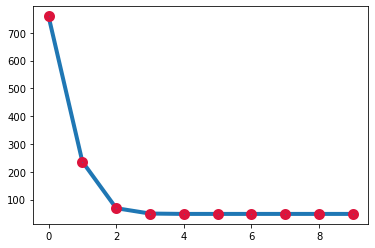

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sse = []
n_cl = list(range(10))

skm = ScratchKMeans(n_clusters = 4, n_init=1, max_iter = 10, tol=0.05, verbose=False)
skm.fit(X)
sse = skm.sse_rec
plt.plot(n_cl, sse, marker="o", markersize=6, markeredgewidth=5, markeredgecolor="crimson", linewidth=4)

# for i in range(1,8):
#     n_cl.append(i)
#     skm = ScratchKMeans(n_clusters = 4, n_init=1, max_iter = 10, tol=0.05, verbose=False)
#     skm.fit(X)
#     sse.append(skm.elbow_sse)
# plt.plot(n_cl, sse, marker="o", markersize=6, markeredgewidth=5, markeredgecolor="crimson", linewidth=4)


In [70]:
import numpy as np
import pandas as pd


data = pd.read_csv("E:/DiveIntoCode/source/Wholesale customers data.csv") # 絶対パス
df.head(20)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)


(440, 2)


[0.45961362 0.86478588 0.93481596 0.97883941 0.99386152 1.
 1.         1.        ]


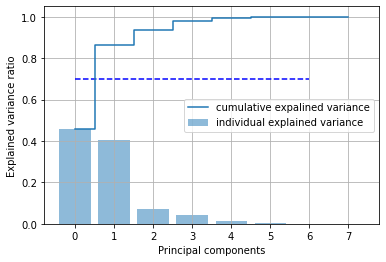

In [66]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=8)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(0,8), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(0,8), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()


### 【問題10】クラスタ数kの選択
最適だと思われるクラスタ数 $k$ を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。<br>


In [ ]:
４
グラフから劇的な変化が見られなくなっているから

### 【問題11】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。<br>


In [ ]:
値が大きすぎて他の値が参考にならなくなる

### 【問題12】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。<br>
<br>
《ヒント》<br>
前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。<br>
条件ごとにデータを見る際にはPandasのgroupbyが便利です。<br>


In [ ]:
食料品（Grocery）が売れている地域では洗剤紙（Detergents_Paper	）も売れている